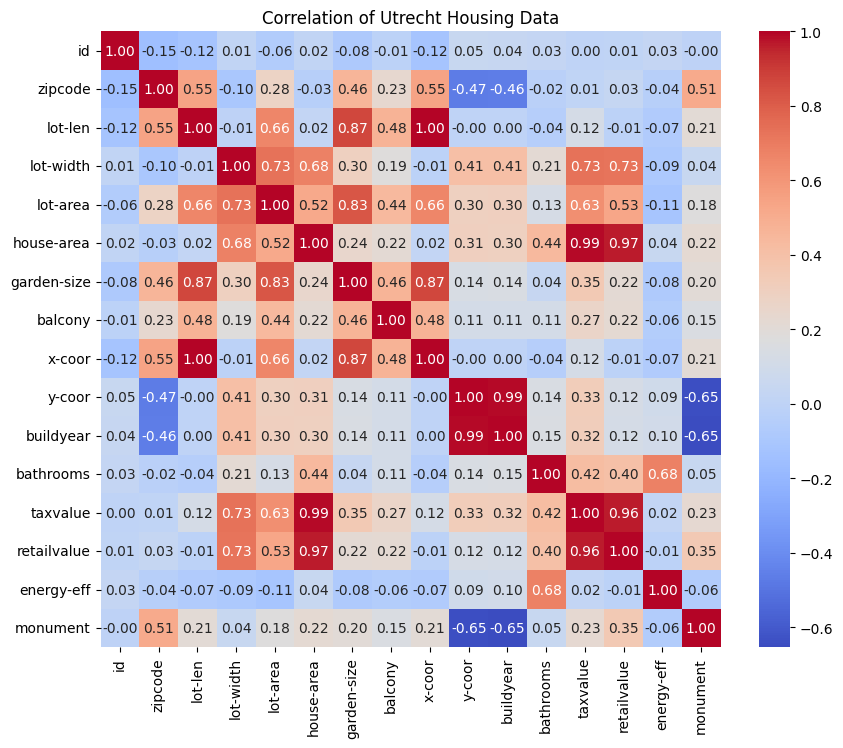

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

utrecht_houses = pd.read_csv("utrechthousinglarge.csv")
numeric_columns = utrecht_houses.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Utrecht Housing Data')
plt.show()

Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.

In [5]:
numeric_columns = utrecht_houses.select_dtypes(include=['int64', 'float64'])

utrecht_houses['Mapped_Label'] = utrecht_houses['y-coor'].apply(lambda x: 1 if x > utrecht_houses['y-coor'].mean() else 0)

correlations = numeric_columns.corrwith(utrecht_houses['Mapped_Label'].abs()).abs().sort_values(ascending=False)

correlations = correlations.drop('Mapped_Label')

top_correlations = correlations.head(5)

print("Top 5 correlated frequencies with the target label:")
print(top_correlations)

Top 5 correlated frequencies with the target label:
y-coor       0.867147
buildyear    0.855560
monument     0.570257
zipcode      0.430107
lot-width    0.381611
dtype: float64


In [6]:
X = numeric_columns.drop('Mapped_Label', axis=1)  # Features
y = utrecht_houses['Mapped_Label']  # Label

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_cv, y_train_cv, test_size=0.1, random_state=42)
print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of validation set:", X_val.shape, y_val.shape)
print("Shape of test set:", X_test.shape, y_test.shape)

Shape of training set: (324, 16) (324,)
Shape of validation set: (36, 16) (36,)
Shape of test set: (40, 16) (40,)


Create a PipeLine that contains both a StandardScaler and a KNN model

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()) 
])

Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.

In [10]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)  

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'knn__n_neighbors': 9}


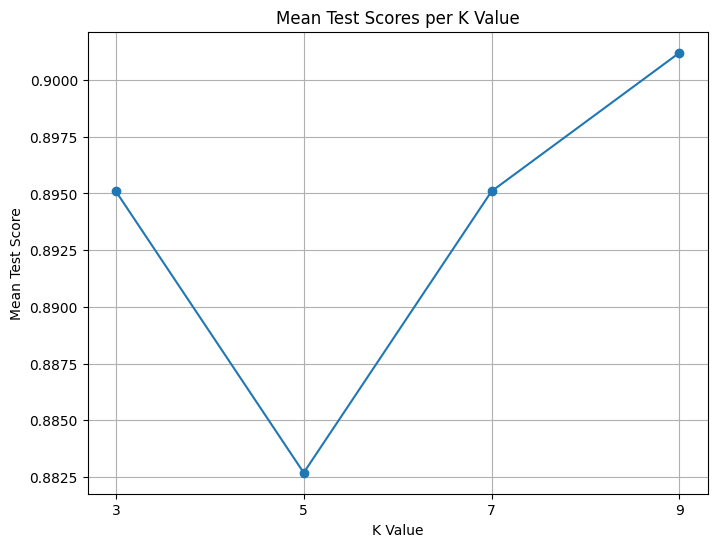

In [11]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
k_values = param_grid['knn__n_neighbors']

plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_test_scores, marker='o', linestyle='-')
plt.title('Mean Test Scores per K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Test Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.

In [12]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        22
           1       0.93      0.72      0.81        18

    accuracy                           0.85        40
   macro avg       0.87      0.84      0.84        40
weighted avg       0.86      0.85      0.85        40

Confusion Matrix:
[[21  1]
 [ 5 13]]
